In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statistics import mode 
import datetime
import csv
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import warnings
from numba import jit, cuda 

<ipython-input-1-50a115bf1654>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [34]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
warnings.filterwarnings("ignore")
os.getcwd()
os.chdir(r'C:\Users\sherw\OneDrive\Desktop\NN_HW4')

In [3]:
plt.style.use(['dark_background'])
plt.rcParams['figure.figsize'] = (2*6.4,2*4.8)

In [4]:
data = pd.read_csv('dataset/IRX6X34T0008.csv',encoding="UTF-16LE",header = 0)
d = data.to_numpy()

# q1:

In [5]:
price = d[:,5]
color_price = list()
for i in range(len(price)):
    if i == 0:
        continue
    else:
        if price[i-1] <= price[i]:
            color_price.append('green')
        else:
            color_price.append('red')
price2 = np.delete(price, 0)

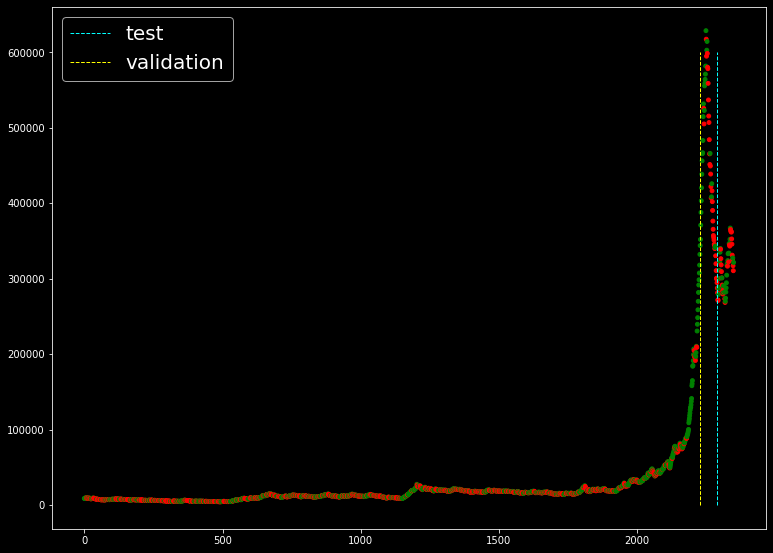

In [70]:
plt.scatter(np.arange(len(price2)),price2,s = 15, c = color_price)
plt.plot([2290,2290],[10,600000],linestyle = '--',linewidth=1,color = 'cyan',label= 'test')
plt.plot([2226,2226],[10,600000],linestyle = '--',linewidth=1,color = 'yellow',label= 'validation')
plt.legend(prop={'size': 20})

In [71]:
train, validation, test = price[np.where(d[:,1]>=13900106)],price[np.where(d[:,1]>=13990401)],price[np.where(d[:,1]>13990631)]

# q2:

In [72]:
d_w = d[[i for i in range(len(d)) if i%20 == 0]]
price_w = price[[i for i in range(len(price)) if i%20 == 0]]
color_price_w = list()
for i in range(len(price_w)):
    if i == 0:
        continue
    else:
        if price_w[i-1] <= price_w[i]:
            color_price_w.append('green')
        else:
            color_price_w.append('red')
price_w2 = np.delete(price_w, 0)

Text(0.5, 1.0, 'window size of 20 time-steps')

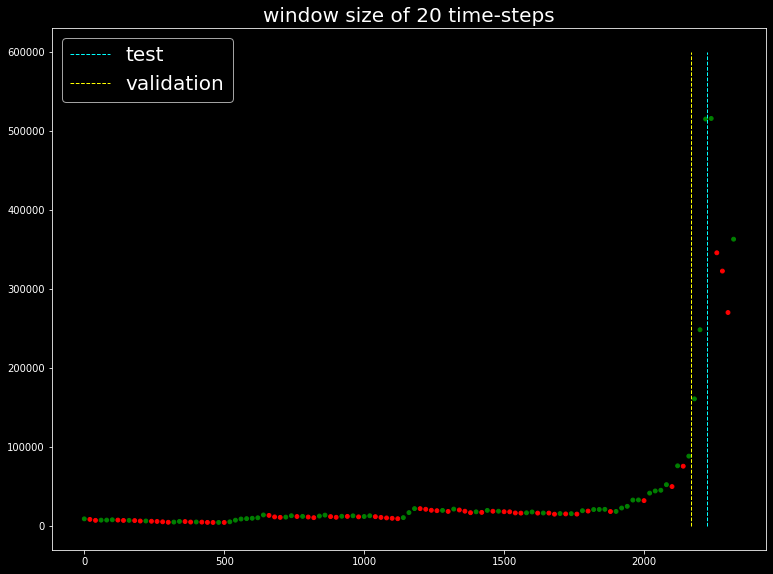

In [73]:
plt.scatter(20*np.arange(len(price_w2)),price_w2,s = 15, c = color_price_w)
plt.plot([2226,2226],[10,600000],linestyle = '--',linewidth=1,color = 'cyan',label= 'test')
plt.plot([2169,2169],[10,600000],linestyle = '--',linewidth=1,color = 'yellow',label= 'validation')
plt.legend(prop={'size': 20})
plt.title('window size of 20 time-steps',size = 20)

In [74]:
_w, validation_w, test_w = price[np.where(d_w[:,1]>=13900106)],price_w[np.where(d_w[:,1]>=13990105)],price_w[np.where(d_w[:,1]>13990331)]

# q3:

## naive model:

RMSE: 7801.289


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


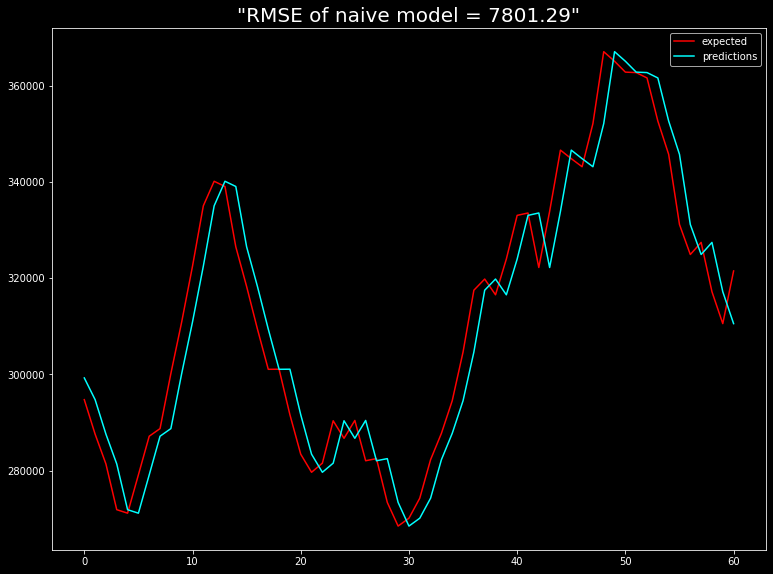

In [75]:
price = np.reshape(price,(len(price),1))
train, test = price[0:2290], price[2290:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	predictions.append(history[-1])
	history.append(test[i])
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(test,label = 'expected',color = 'red')
plt.plot(predictions,label = 'predictions',color = 'cyan')
plt.title('"RMSE of naive model = {:.2f}"'.format(rmse),size = 20)
plt.legend()
plt.show()

## defined functions:

In [76]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    if i % 10 == 0:
      print(i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

## data preparation:

In [77]:
raw_values = price
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

portion = int((26/1000)*len(price))
train, test = supervised_values[0:-portion], supervised_values[-portion:]

scaler, train_scaled, test_scaled = scale(train, test)

In [80]:
supervised.shape

(2350, 2)

In [81]:
supervised

,0,0
0,0,[248.6999999999989]
1,[248.6999999999989],[139.5]
2,[139.5],[132.70000000000073]
3,[132.70000000000073],[78.29999999999927]
4,[78.29999999999927],[156.3000000000011]
...,...,...
2345,[-14581.0],[-6237.0]
2346,[-6237.0],[2511.0]
2347,[2511.0],[-10252.0]
2348,[-10252.0],[-6633.0]


In [89]:
diff_values

0        [248.6999999999989]
1                    [139.5]
2       [132.70000000000073]
3        [78.29999999999927]
4        [156.3000000000011]
                ...         
2345               [-6237.0]
2346                [2511.0]
2347              [-10252.0]
2348               [-6633.0]
2349               [10950.0]
Length: 2350, dtype: object

## basic model:

In [117]:
repeat = 2
rmses = []
for r in range(repeat):
    lstm_model = fit_lstm(train_scaled, 1, 25, 3)
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    predictions = list()
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]

    rmse = sqrt(mean_squared_error(raw_values[2290:], predictions))
    rmses.append(rmse)
avg_rmse = np.mean(rmses)

0
5
10
15
20


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0
5
10
15
20


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


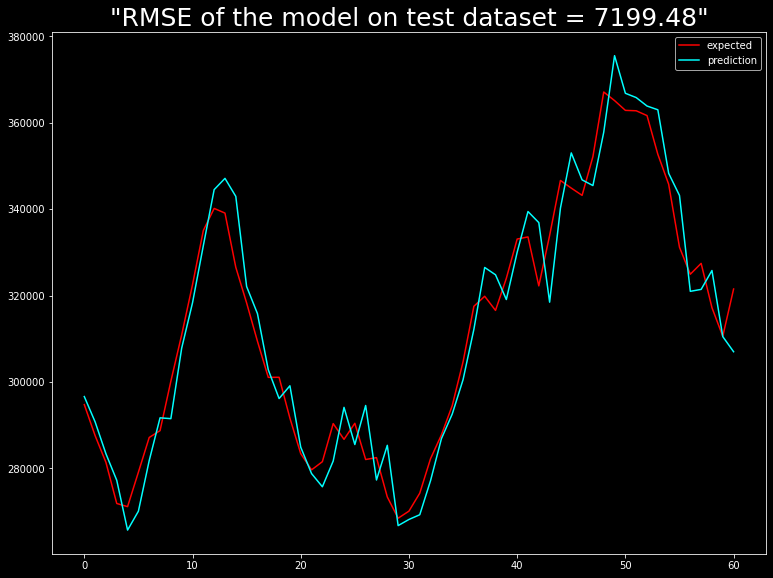

In [118]:
plt.plot(raw_values[2290:],color = 'red', label = 'expected')
plt.plot(predictions,color = 'cyan', label = 'prediction')
plt.title('"RMSE of the model on test dataset = {:.2f}"'.format(avg_rmse),size = 25)
plt.legend()
plt.show()

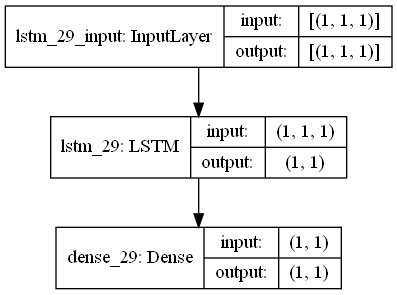

In [94]:
keras.utils.plot_model(lstm_model,show_shapes = True)

## stacked LSTM:

In [266]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    if i % 5 == 0:
      print(i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model

n_neuron = 1
n_layers = 2
raw_values = price
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

portion = int((26/1000)*len(price))
train, test = supervised_values[0:-portion], supervised_values[-portion:]

scaler, train_scaled, test_scaled = scale(train, test)

repeat = 1
rmses = []
for r in range(repeat):
    lstm_model = fit_lstm(train_scaled, 1, 30, n_neuron)
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    predictions = list()
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]

    rmse = sqrt(mean_squared_error(raw_values[2290:], predictions))
    rmses.append(rmse)
avg_rmse = np.mean(rmses)

0
5
10
15
20
25


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


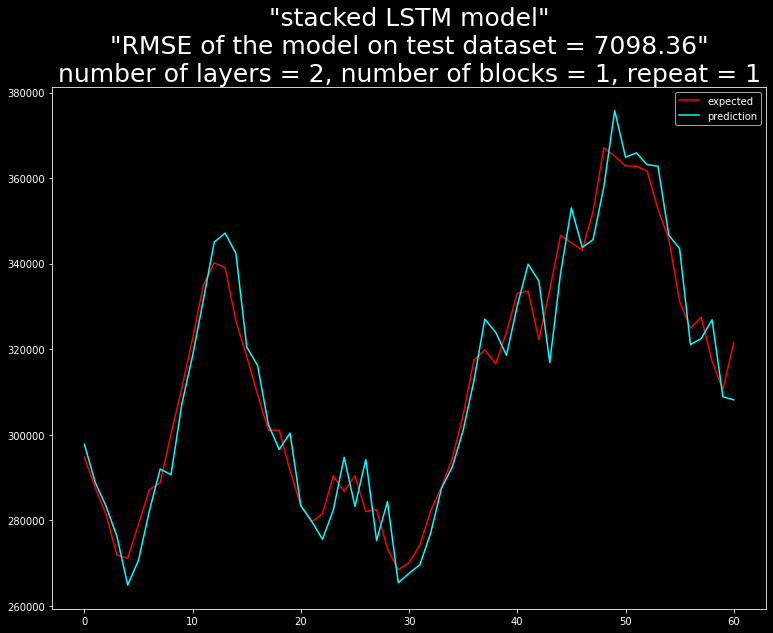

In [276]:
plt.plot(raw_values[2290:],color = 'red', label = 'expected')
plt.plot(predictions,color = 'cyan', label = 'prediction')
plt.title('"stacked LSTM model"\n"RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}, repeat = {}'
          .format(avg_rmse,n_layers,n_neuron,repeat),size = 25)
plt.legend()
plt.show()

In [166]:
predictions = [item for sublist in predictions for item in sublist]

In [168]:
color_predictions = list()
for i in range(len(predictions)):
    if i == 0:
        continue
    else:
        if predictions[i-1] <= predictions[i]:
            color_predictions.append('green')
        else:
            color_predictions.append('red')
predictions2 = np.delete(predictions, 0)

Text(0.5, 1.0, '"stacked LSTM model"\n"RMSE of the model on test dataset = 7033.75"\nnumber of layers = 2, number of blocks = 1, repeat = 1')

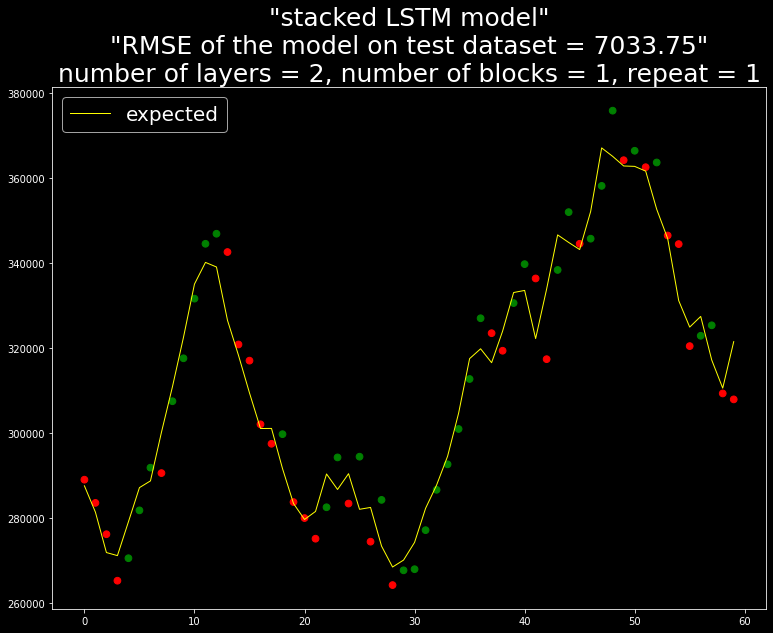

In [201]:
plt.scatter(np.arange(len(predictions2)),predictions2,s = 45, c = color_predictions)
plt.plot(raw_values[2291:],linewidth=1,c = 'yellow',label = 'expected')
plt.legend(prop={'size': 20})
plt.title('"stacked LSTM model"\n"RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}, repeat = {}'
          .format(avg_rmse,n_layers,n_neuron,repeat),size = 25)

## windowed dataset:

RMSE: 136456.502


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


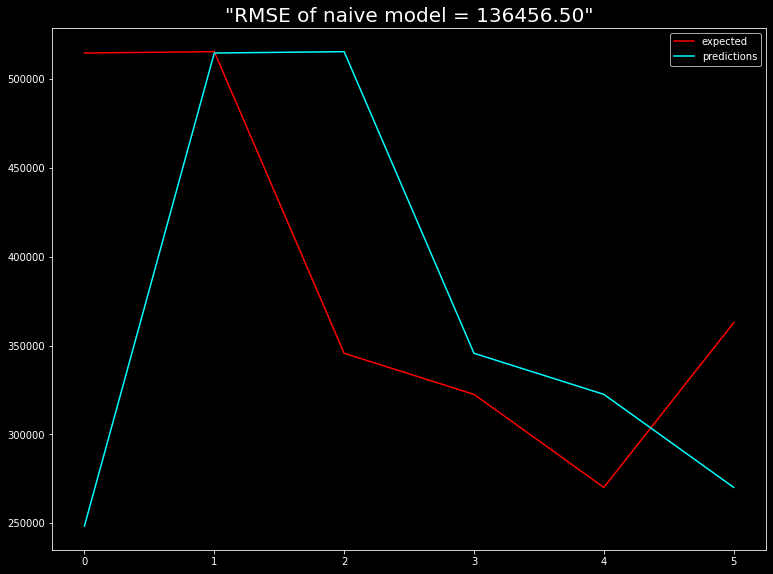

In [296]:
portion = int((51/1000)*len(price_w))
price_w = np.reshape(price_w,(len(price_w),1))
train, test = price_w[0:-portion], price_w[-portion:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	predictions.append(history[-1])
	history.append(test[i])
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(test,label = 'expected',color = 'red')
plt.plot(predictions,label = 'predictions',color = 'cyan')
plt.title('"RMSE of naive model = {:.2f}"'.format(rmse),size = 20)
plt.legend()
plt.show()

In [338]:
## data preparation:

raw_values = price_w.reshape(len(price_w),1)
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

portion = int((51/1000)*len(price_w))
train, test = supervised_values[0:-portion], supervised_values[-portion:]

scaler, train_scaled, test_scaled = scale(train, test)

## basic model:

n_neuron = 3
n_layers = 1
repeat = 1
rmses = []
for r in range(repeat):
    lstm_model = fit_lstm(train_scaled, 1, 600, n_neuron)
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    predictions = list()
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]

    rmse = sqrt(mean_squared_error(raw_values[-portion:], predictions))
    rmses.append(rmse)
avg_rmse = np.mean(rmses)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


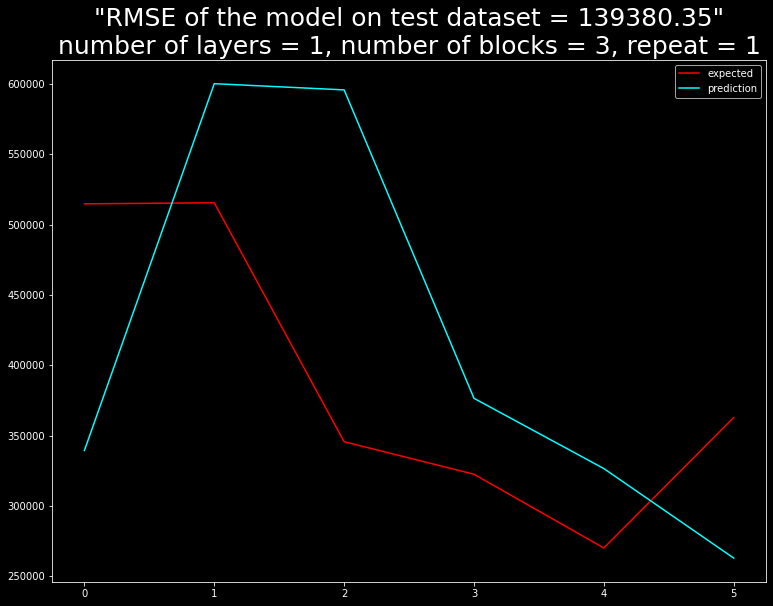

In [339]:
plt.plot(raw_values[-6:],color = 'red', label = 'expected')
plt.plot(predictions,color = 'cyan', label = 'prediction')
plt.title('"RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}, repeat = {}'.format(avg_rmse,n_layers,n_neuron,repeat),size = 25)
plt.legend()
plt.show()

In [321]:
## stacked LSTM:

def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    if i % 5 == 0:
      print(i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model

n_neuron = 3
n_layers = 2
raw_values = price_w.reshape(len(price_w),1)
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

portion = int((51/1000)*len(price_w))
train, test = supervised_values[0:-portion], supervised_values[-portion:]

scaler, train_scaled, test_scaled = scale(train, test)

repeat = 1
rmses = []
for r in range(repeat):
    lstm_model = fit_lstm(train_scaled, 1, 300, n_neuron)
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    predictions = list()
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]

    rmse = sqrt(mean_squared_error(raw_values[-portion:], predictions))
    rmses.append(rmse)
avg_rmse = np.mean(rmses)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295


C:\Users\sherw\anaconda3\envs\pip\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


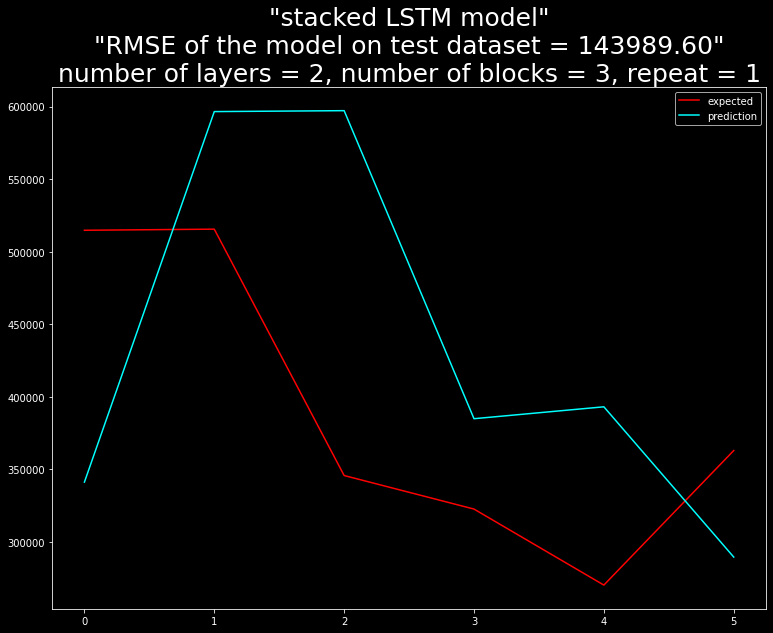

In [322]:
plt.plot(raw_values[-portion:],color = 'red', label = 'expected')
plt.plot(predictions,color = 'cyan', label = 'prediction')
plt.title('"stacked LSTM model"\n"RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}, repeat = {}'
          .format(avg_rmse,n_layers,n_neuron,repeat),size = 25)
plt.legend()
plt.show()

Text(0.5, 1.0, '"RMSE of the model on test dataset = 119504.92"\nnumber of layers = 1, number of blocks = 3, repeat = 1')

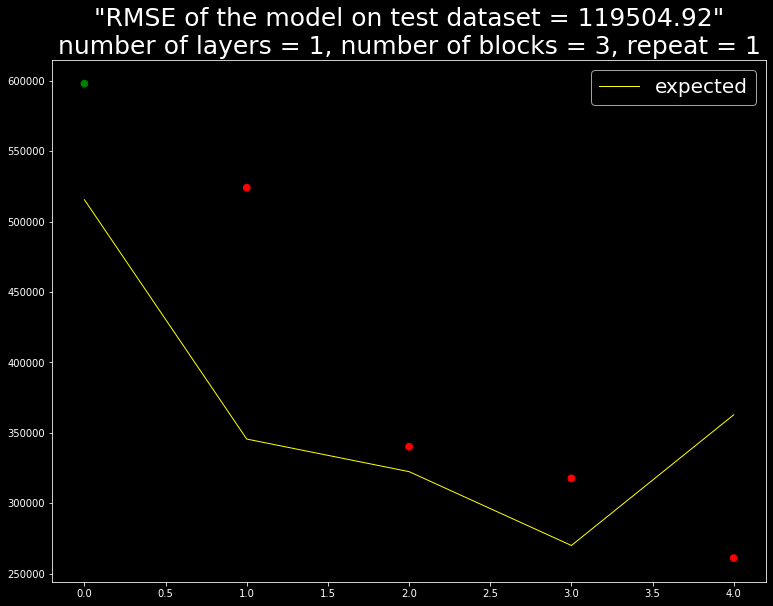

In [333]:
predictions = [item for sublist in predictions for item in sublist]

color_predictions = list()
for i in range(len(predictions)):
    if i == 0:
        continue
    else:
        if predictions[i-1] <= predictions[i]:
            color_predictions.append('green')
        else:
            color_predictions.append('red')
predictions2 = np.delete(predictions, 0)

plt.scatter(np.arange(len(predictions2)),predictions2,s = 45, c = color_predictions)
plt.plot(raw_values[-portion+1:],linewidth=1,c = 'yellow',label = 'expected')
plt.legend(prop={'size': 20})
plt.title('"RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}, repeat = {}'
          .format(avg_rmse,n_layers,n_neuron,repeat),size = 25)

# q4

# q5:

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print(i)
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmses = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmses.append(rmse)
        print('t+{} RMSE: {:.2f}'.format((i+1), rmse))
    return(rmses)

## regular dataset:

In [105]:
price_df = pd.DataFrame(price)
series = price_df
portion = int((26/1000)*len(price))

n_lag = 1
n_seq = 20
n_test = portion-n_seq
n_epochs = 60
n_batch = 1
n_neurons = 1
n_layers = 1
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+n_seq-1)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+n_seq-1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [106]:
rmses = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 6650.40
t+2 RMSE: 12290.53
t+3 RMSE: 17522.70
t+4 RMSE: 22190.10
t+5 RMSE: 27027.01
t+6 RMSE: 32120.49
t+7 RMSE: 36020.42
t+8 RMSE: 39695.95
t+9 RMSE: 42504.04
t+10 RMSE: 44594.52
t+11 RMSE: 45522.70
t+12 RMSE: 45550.81
t+13 RMSE: 45855.15
t+14 RMSE: 47166.37
t+15 RMSE: 49876.96
t+16 RMSE: 52756.49
t+17 RMSE: 55680.75
t+18 RMSE: 59019.27
t+19 RMSE: 62961.90
t+20 RMSE: 65862.54


21


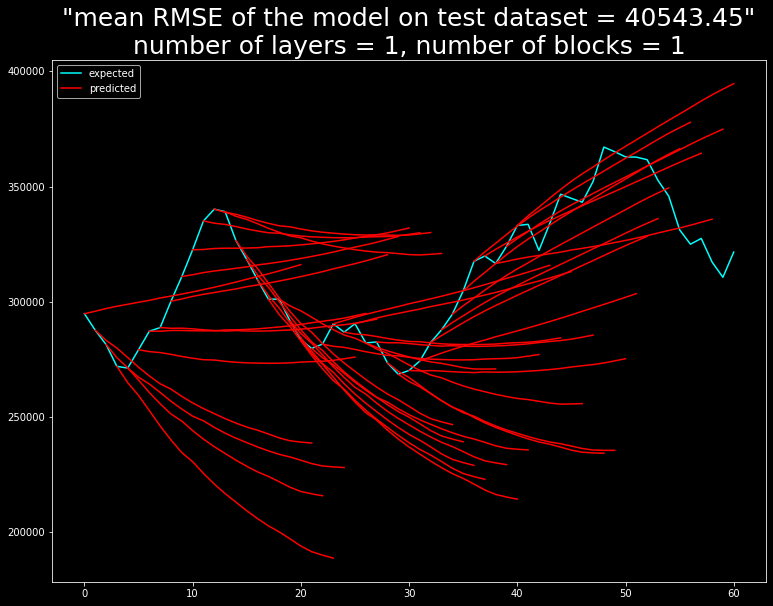

In [108]:
def plot_forecasts(series, forecasts, n_test, portion,avg_rmse,n_l,n_n):
    values = []
    plt.plot(series.values,color = 'cyan', label = 'expected')
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        values.append(yaxis)
        if i == 0:
            plt.plot(xaxis[:portion], yaxis[:portion], color='red',label = 'predicted')
        else:
            plt.plot(xaxis[:portion], yaxis[:portion], color='red')
    print(portion)
    plt.title('"mean RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
, number of blocks = {}'.format(avg_rmse,n_layers,n_neurons),size = 25)
    plt.legend()
    plt.show()
    return values
avg = np.mean(rmses) 
vals = plot_forecasts(series[-portion:], forecasts, n_test+n_seq-1,21,avg,n_layers,n_neurons)

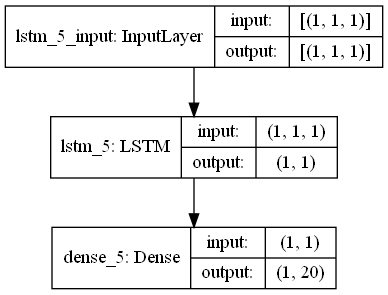

In [38]:
keras.utils.plot_model(model,show_shapes = True)

## stacked LSTM model:

In [91]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True,return_sequences = True))
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print(i)
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
price_df = pd.DataFrame(price)
series = price_df
portion = int((26/1000)*len(price))

n_lag = 1
n_seq = 20
n_test = portion-n_seq
n_epochs = 20
n_batch = 1
n_neurons = 2
n_layers = 2
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+n_seq-1)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+n_seq-1)

In [ ]:
rmses = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

21


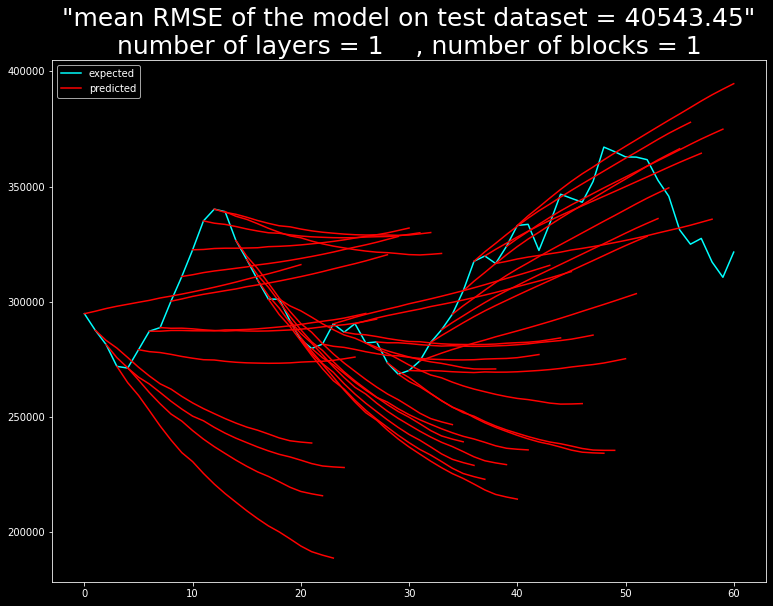

In [181]:
def plot_forecasts(series, forecasts, n_test, portion,avg_rmse,n_l,n_n):
    
    plt.plot(series.values,color = 'cyan', label = 'expected')
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        if i == 0:
            plt.plot(xaxis[:portion], yaxis[:portion], color='red',label = 'predicted')
        else:
            plt.plot(xaxis[:portion], yaxis[:portion], color='red')
    print(portion)
    plt.title('"mean RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
    , number of blocks = {}'.format(avg_rmse,n_layers,n_neurons),size = 25)
    plt.legend()
    plt.show()
avg = np.mean(rmses) 
plot_forecasts(series[-portion:], forecasts, n_test+n_seq-1,21,avg,n_layers,n_neurons)

In [136]:
all_colors = []
vals2 = []
for i in range(len(vals)):
    predictions = [item for sublist in vals[i] for item in sublist]

    color_predictions = list()
    for i in range(len(predictions)):
        if i == 0:
            continue
        else:
            if predictions[i-1] <= predictions[i]:
                color_predictions.append('green')
            else:
                color_predictions.append('red')
    all_colors.append(color_predictions)
    predictions2 = np.delete(predictions, 0)
    vals2.append(predictions2)

In [169]:
vals_temp = np.concatenate( vals2, axis=0 )

In [176]:
vals_temp = np.reshape(vals_temp,(len(vals2),len(vals2[0]),1))

In [186]:
vals_temp[0]

array([[295819.05102539],
       [297001.27233887],
       [297991.11480713],
       [298846.94744873],
       [299715.67718506],
       [300546.54602051],
       [301584.98974609],
       [302404.894104  ],
       [303277.46099854],
       [304210.38238525],
       [305214.65802002],
       [306241.83721924],
       [307336.03326416],
       [308491.00421143],
       [309731.22601318],
       [310916.28082275],
       [312090.26837158],
       [313344.65765381],
       [314701.8727417 ],
       [316067.16278076]])

In [197]:
np.array([series.values[0]]).shape

(1, 1)

In [195]:
vals_temp[0].shape

(20, 1)

In [ ]:
np.array([series.values[off_s]])

21


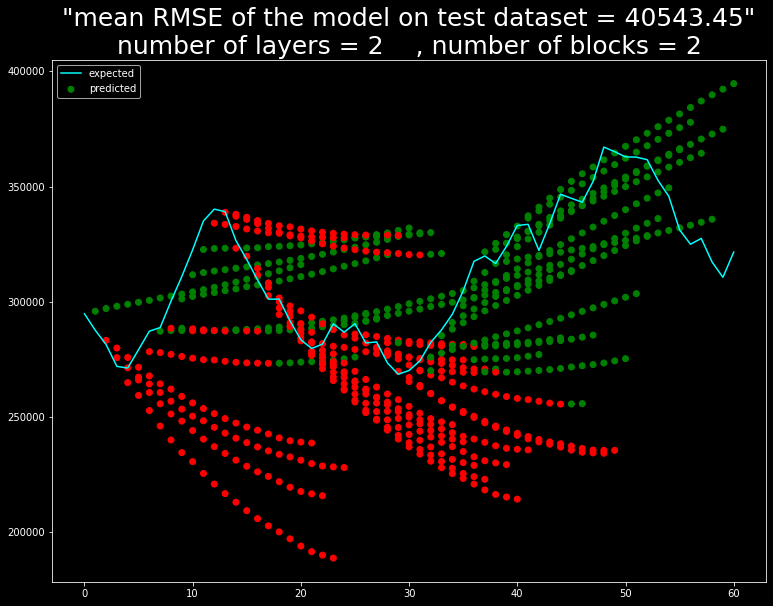

In [203]:
def plot_forecasts(series, forecasts, n_test, portion,avg_rmse,n_l,n_n,colors):
    
    plt.plot(series.values,color = 'cyan', label = 'expected')
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
#         yaxis = np.array([series.values[off_s]]) + forecasts[i]
        yaxis = forecasts[i]
        if i == 0:
            plt.scatter(xaxis[1:portion], yaxis[:portion], color=colors[i],label = 'predicted')
        else:
            plt.scatter(xaxis[1:portion], yaxis[:portion], color=colors[i])
    print(portion)
    plt.title('"mean RMSE of the model on test dataset = {:.2f}"\nnumber of layers = {}\
    , number of blocks = {}'.format(avg_rmse,n_l,n_n),size = 25)
    plt.legend()
    plt.show()
avg = np.mean(rmses) 
plot_forecasts(series[-portion:], vals_temp, n_test+n_seq-1,21,avg,2,2,all_colors)